In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,TimeSeriesSplit, cross_val_predict
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(file_path):
    data = pd.read_excel(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    return data


In [3]:
# Exploratory Data Analysis (EDA) function
def perform_eda(data):
    
#     # Create subplots with a 2-column layout
#     fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))


    # Extract year and net revenue columns
    data['Year'] = data['Date'].dt.year

    # Group data by year and sum net revenue
    yearly_revenue = data.groupby('Year')['Net_Revenue'].sum()
    
    # Plot the yearly net revenue as a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_revenue.index, yearly_revenue.values, marker='o')
    plt.title('Yearly Net Revenue')
    plt.xlabel('Year')
    plt.ylabel('Net Revenue')
    plt.xticks(yearly_revenue.index, rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Seasonal Decomposition


    decomposition = seasonal_decompose(data['Net_Revenue'], model='additive', period=52)  # Assuming weekly data
    decomposition.plot()
    plt.show()

    # ACF and PACF plots
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plot_acf(data['Net_Revenue'], lags=50)
    plot_pacf(data['Net_Revenue'], lags=50)
    plt.show()
    
    # Heatmap and Correlation Analysis
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Rolling Statistics
    rolling_mean = data['Net_Revenue'].rolling(window=4).mean()  # Adjust window size as needed
    rolling_std = data['Net_Revenue'].rolling(window=4).std()  # Adjust window size as needed

    plt.plot(data['Net_Revenue'], label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Statistics')
    plt.show()

    # Histogram and Density Plot
    sns.histplot(data['Net_Revenue'], kde=True)
    plt.title('Net Revenue Distribution')
    plt.show()

    # Lag Scatter Plot
    lagged_values = pd.concat([data['Net_Revenue'], data['Net_Revenue'].shift(1)], axis=1)
    lagged_values.columns = ['Net_Revenue', 'Net_Revenue_lag_1']

    sns.scatterplot(data=lagged_values, x='Net_Revenue_lag_1', y='Net_Revenue')
    plt.title('Lag Scatter Plot')
    plt.show()

    # Monthly Patterns (Example: assuming monthly data)
    monthly_data = data.resample('M', on='Date').sum()
    plt.plot(monthly_data['Net_Revenue'])
    plt.title('Monthly Net Revenue Patterns')
    plt.xlabel('Month')
    plt.ylabel('Net Revenue')
    plt.xticks(rotation=45)
    plt.show()

    # Cross-Correlation Analysis
    cross_correlation = data[['Net_Revenue', 'business_days', 'holidays']].corr()
    sns.heatmap(cross_correlation, annot=True, cmap='coolwarm')
    plt.title('Cross-Correlation Heatmap')
    plt.show()

    # Outlier Detection
    plt.boxplot(data['Net_Revenue'])
    plt.title('Box Plot of Net Revenue (Outlier Detection)')
    plt.show()


    # Histogram and Distribution Plot
    plt.figure(figsize=(10, 6))
    plt.hist(data['Net_Revenue'], bins=20, edgecolor='black')
    plt.xlabel('Net Revenue')
    plt.ylabel('Frequency')
    plt.title('Net Revenue Distribution')
    plt.show()

    # Box Plot by Year
    data['Year'] = data['Date'].dt.year
    plt.figure(figsize=(10, 6))
    data.boxplot(column='Net_Revenue', by='Year', showfliers=False)
    plt.xlabel('Year')
    plt.ylabel('Net Revenue')
    plt.title('Net Revenue Distribution by Year')
    plt.suptitle('')  # Remove default title
    plt.show()

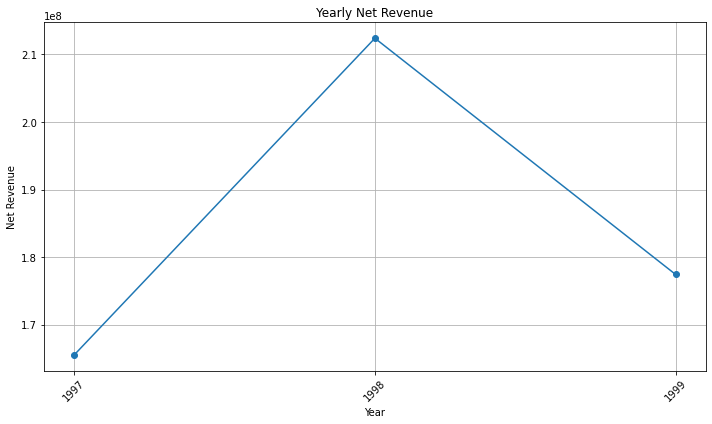

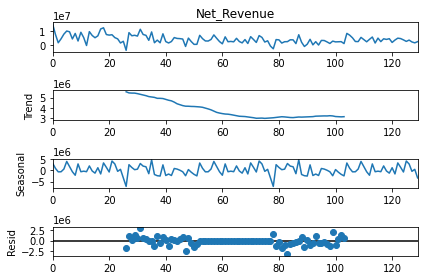

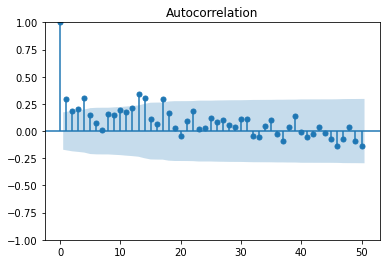

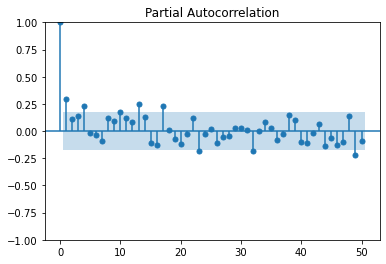

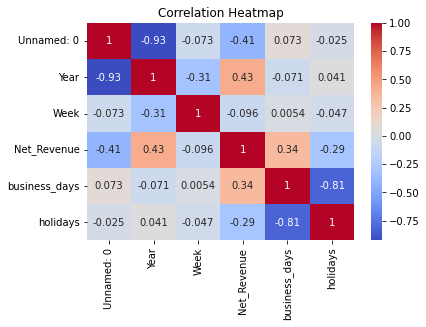

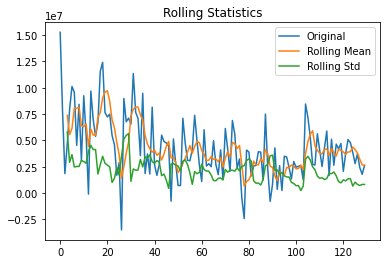

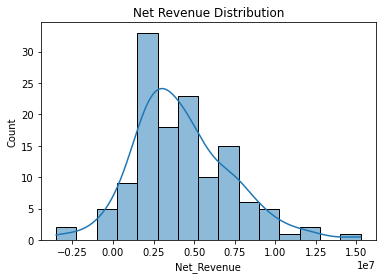

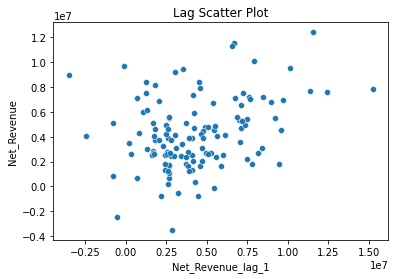

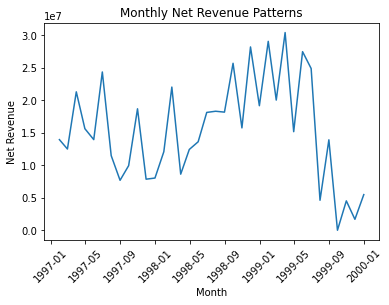

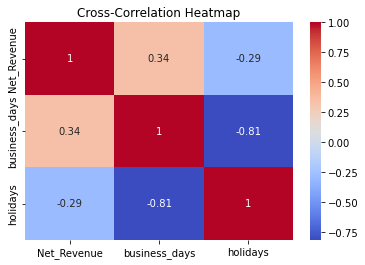

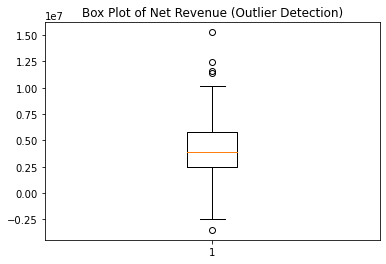

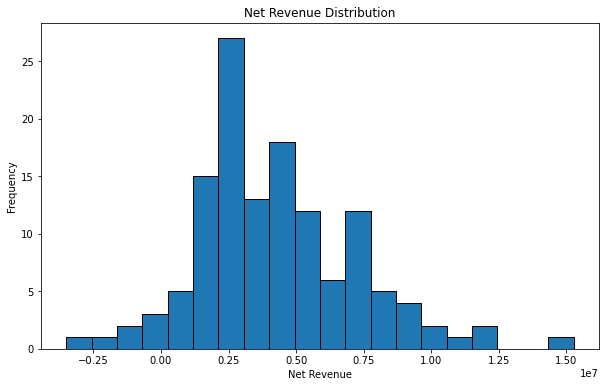

<Figure size 720x432 with 0 Axes>

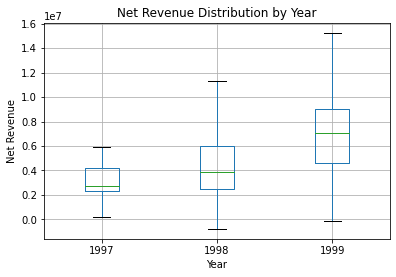

DataFrame with next 8 weeks of Date and corresponding predictions:
          Date      Forecast
122 1999-12-12  3.870418e+06
123 1999-12-19  3.777943e+06
124 1999-12-26  3.307269e+06
125 2000-01-02  3.568641e+06
126 2000-01-09  3.660480e+06
127 2000-01-16  3.626212e+06
128 2000-01-23  3.531730e+06
129 2000-01-30  3.572409e+06
RMSE :  1052647.2261432796
MAPE :  34.37009011911407


In [4]:

# Train the ARIMA model on the training data
def train_arima_model(train_data):
    model = ARIMA(train_data['Net_Revenue'], order=(5, 1, 0))  # ARIMA model with order (p, d, q)
    fitted_model = model.fit()  # Fit the model to the training data
    return fitted_model

# Forecast using the trained ARIMA model
def forecast_arima_model(model, num_forecasts):
    forecasts = model.forecast(steps=num_forecasts)  # Make 'num_forecasts' future predictions
    return forecasts

# Evaluate the forecasts using RMSE and MAPE metrics
def evaluate_forecasts(actual, forecasts):
    rmse = np.sqrt(mean_squared_error(actual, forecasts))  # Calculate RMSE
    mape = np.mean(np.abs((actual - forecasts) / actual)) * 100  # Calculate MAPE
    return rmse, mape

def main(file_path="time_series_data.xlsx"):
    num_forecasts = 8  # Number of future forecasts to make

    # Load data from the provided file path
    data = load_data(file_path)
    
    # Perform Exploratory Data Analysis (EDA)
    perform_eda(data)
    
    # Split the data into training and test sets
    train_data = data[:-num_forecasts]  # Training data
    test_data = data[-num_forecasts:]   # Test data for validation
    
    # Train the ARIMA model on the training data
    model = train_arima_model(train_data)
    
    # Forecast using the trained ARIMA model
    forecasts = forecast_arima_model(model, num_forecasts)
    
    # Get actual values for comparison
    actual_values = test_data['Net_Revenue'].values
    
    # Evaluate the forecasts using RMSE and MAPE metrics
    rmse, mape = evaluate_forecasts(actual_values, forecasts)
    
    # Create a DataFrame with next 8 weeks of Date and corresponding predictions
    forecast_dates = pd.date_range(start=data['Date'].max(), periods=num_forecasts+1, freq='W')[1:]
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecasts})
    
    # Print the results
    print("DataFrame with next 8 weeks of Date and corresponding predictions:")
    print(forecast_df)
    print('RMSE : ',rmse) 

    print('MAPE : ',mape) 

if __name__ == "__main__":
    main()
